In [199]:
from sklearn.cluster import KMeans
import json
import pandas as pd
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [164]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")
# model.cuda()  # uncomment it if you have a GPU

def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu()

def parse_json(data):
    return list(embed_bert_cls(data["title"], model, tokenizer))[:100] \
        + list(embed_bert_cls(data["maintext"], model, tokenizer))

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [165]:
with open('parsed_news.json', 'rb') as f:
    data = json.load(f)

In [166]:
title = []
main_text = []
embeds = []
sources = []
urls = []

for news in data:
    sources.append(news['source_domain'])
    urls.append(news['url'])
    title.append(news['title'])
    main_text.append(news['maintext'])
    embeds.append(parse_json(news))
df = pd.DataFrame({'title' : title
                 , 'main_text' : main_text
                 , 'embed' : embeds
                 , 'source' : sources
                 , 'url' : urls})

In [167]:
df['embeds'] = list([[float(i) for i in s] for s in df['embed']])

In [168]:
df.drop(columns=['embed'], inplace=True)

In [169]:
feats_emb = [f'emb_{str(i)}' for i in range(412)]

In [170]:
for i, feat in enumerate(feats_emb):
    df[feat] = [df['embeds'][j][i] for j in range(df.shape[0])]

C:\Users\danie\AppData\Local\Temp\ipykernel_12712\1079347849.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feat] = [df['embeds'][j][i] for j in range(df.shape[0])]
C:\Users\danie\AppData\Local\Temp\ipykernel_12712\1079347849.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feat] = [df['embeds'][j][i] for j in range(df.shape[0])]
C:\Users\danie\AppData\Local\Temp\ipykernel_12712\1079347849.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

In [52]:
dist_matr = cosine_similarity(df[feats_emb], df[feats_emb])

In [55]:
for i in range(dist_matr.shape[0]):
    dist_matr[i][i] = 0

In [68]:
s = set()
for i in range(dist_matr.shape[0]):
    s.update(list(dist_matr[i][i+1:]))

In [72]:
dists = np.array(sorted(list(s)))

In [155]:
threshold = np.quantile(dists, q=0.95)

In [156]:
near_texts = []
n = dist_matr.shape[0]
for i in range(n):
    for j in range(n):
        if dist_matr[i][j] > threshold:
            near_texts.append({'dist' : dist_matr[i][j]
                             , 'id_1' : i
                             , 'title_1' : df.iloc[i]['title']
                             , 'text_1' : df.iloc[i]['main_text']
                             , 'url_1' : df.iloc[i]['url']
                             , 'id_2' : j
                             , 'title_2' : df.iloc[j]['title']
                             , 'text_2' : df.iloc[j]['main_text']
                             , 'url_2' : df.iloc[j]['url']})

In [157]:
near_texts[200000]

{'dist': 0.9125848546062475,
 'id_1': 1667,
 'title_1': 'Ведущие турецкие банки больше не обслуживают российскую карту "МИР"',
 'text_1': 'Бухгалтеры, переучивайтесь на маркетологов и зарабатывайте от 70 000 рублей!\nОсвойте актуальную и прибыльную профессию в 2023 году. Маркетологи нужны каждому бизнесу — вы будете приносить доход и станете ценным сотрудником.\nМы выпустили новый курс профпереподготовки и за два месяца сделаем из вас маркетолога. Коротко о том, что будете уметь:\n• анализировать целевую аудиторию и конкурентов;\n• разрабатывать маркетинговую стратегию;\n• строить продуктовые гипотезы.\nПо выгодной цене курс стоит 49 990₽. Вы получите красный диплом с внесением в ФИС ФРДО. Смотрите программу курса здесь или заполняйте форму ниже — расскажем больше.',
 'url_1': 'https://www.klerk.ru/buh/news/535481/',
 'id_2': 1704,
 'title_2': 'Если владеть долей в ООО более 5 лет, при выходе можно не платить НДФЛ',
 'text_2': 'Бухгалтеры, переучивайтесь на маркетологов и зарабатывайте

In [158]:
df

,title,main_text,embed,source,url
0,С 2023 года единый налоговый платеж станет обя...,Во втором полугодии 2022 года организации и ИП...,"[tensor(0.0310), tensor(-0.0439), tensor(-0.03...",www.consultant.ru,http://www.consultant.ru/legalnews/19674/
1,"Суды не согласились с наказанием работника, ко...",Работник отказался от командировки. Ему вынесл...,"[tensor(0.0212), tensor(-0.0753), tensor(-0.05...",www.consultant.ru,http://www.consultant.ru/legalnews/19670/
2,Медпомощь взрослым при ожирении будут оказыват...,Диагностику и лечение ожирения у взрослых стан...,"[tensor(0.0285), tensor(-0.0588), tensor(-0.00...",www.consultant.ru,http://www.consultant.ru/legalnews/19669/
3,С 1 июля разрешили менять существенные условия...,"Существенные условия контрактов, которые заклю...","[tensor(0.0427), tensor(-0.0664), tensor(-0.03...",www.consultant.ru,http://www.consultant.ru/legalnews/19668/
4,Составляем полугодовую бюджетную и бухгалтерск...,В этом году важно иметь в виду ряд новшеств. Т...,"[tensor(0.0384), tensor(-0.0574), tensor(-0.00...",www.consultant.ru,http://www.consultant.ru/legalnews/19667/
...,...,...,...,...,...
2067,Тинькофф запустил переводы в евро и долларах д...,По этим направлениям выросло число экспортно-и...,"[tensor(0.0825), tensor(-0.0547), tensor(-0.03...",www.klerk.ru,https://www.klerk.ru/buh/news/534572/
2068,Мосбиржа открывает нерезидентам доступ к торга...,Новым клиентам также станет доступно совершени...,"[tensor(0.0570), tensor(-0.0886), tensor(0.012...",www.klerk.ru,https://www.klerk.ru/buh/news/534571/
2069,При приеме на работу дембеля не надо никуда сл...,"Речь идет о перечне перечень должностей, при н...","[tensor(-0.0323), tensor(-0.0160), tensor(-0.0...",www.klerk.ru,https://www.klerk.ru/buh/news/534570/
2070,ЦБ запретил банкам ущемлять инвалидов и пенсио...,Регулятор выпустил информационное письмо с рек...,"[tensor(0.0627), tensor(-0.0801), tensor(-0.02...",www.klerk.ru,https://www.klerk.ru/buh/news/534566/


In [159]:
df[df['source'] == 'www.klerk.ru']['main_text']

1092    Бухгалтеры, переучивайтесь на маркетологов и з...
1093    До недавнего времени был временный порядок све...
1094    Бухгалтеры, переучивайтесь на маркетологов и з...
1095    В 2022 году учатся или уже закончили обучение ...
1096    Обсуждение затеяли наши подписчики в канале «К...
                              ...                        
2067    По этим направлениям выросло число экспортно-и...
2068    Новым клиентам также станет доступно совершени...
2069    Речь идет о перечне перечень должностей, при н...
2070    Регулятор выпустил информационное письмо с рек...
2071    Ограничительная мера распространяется на сделк...
Name: main_text, Length: 980, dtype: object

In [160]:
ids = set()
for i in range(near_texts.__len__()):
    ids.add(near_texts[i]['id_1'])
    ids.add(near_texts[i]['id_2'])
print(ids.__len__())

1254


In [171]:
n_clusters = 4
clustering = KMeans(n_clusters=n_clusters)
clusters = clustering.fit_predict(df[feats_emb])


In [175]:
df['clust_4'] = clusters

In [195]:
df[df['clust_4'] == 1]['source'].unique()
df[df['clust_4'] == 3]['main_text'].unique()

array(['www.consultant.ru', 'www.klerk.ru'], dtype=object)

In [162]:
df

,title,main_text,embed,source,url
0,С 2023 года единый налоговый платеж станет обя...,Во втором полугодии 2022 года организации и ИП...,"[tensor(0.0310), tensor(-0.0439), tensor(-0.03...",www.consultant.ru,http://www.consultant.ru/legalnews/19674/
1,"Суды не согласились с наказанием работника, ко...",Работник отказался от командировки. Ему вынесл...,"[tensor(0.0212), tensor(-0.0753), tensor(-0.05...",www.consultant.ru,http://www.consultant.ru/legalnews/19670/
2,Медпомощь взрослым при ожирении будут оказыват...,Диагностику и лечение ожирения у взрослых стан...,"[tensor(0.0285), tensor(-0.0588), tensor(-0.00...",www.consultant.ru,http://www.consultant.ru/legalnews/19669/
3,С 1 июля разрешили менять существенные условия...,"Существенные условия контрактов, которые заклю...","[tensor(0.0427), tensor(-0.0664), tensor(-0.03...",www.consultant.ru,http://www.consultant.ru/legalnews/19668/
4,Составляем полугодовую бюджетную и бухгалтерск...,В этом году важно иметь в виду ряд новшеств. Т...,"[tensor(0.0384), tensor(-0.0574), tensor(-0.00...",www.consultant.ru,http://www.consultant.ru/legalnews/19667/
...,...,...,...,...,...
2067,Тинькофф запустил переводы в евро и долларах д...,По этим направлениям выросло число экспортно-и...,"[tensor(0.0825), tensor(-0.0547), tensor(-0.03...",www.klerk.ru,https://www.klerk.ru/buh/news/534572/
2068,Мосбиржа открывает нерезидентам доступ к торга...,Новым клиентам также станет доступно совершени...,"[tensor(0.0570), tensor(-0.0886), tensor(0.012...",www.klerk.ru,https://www.klerk.ru/buh/news/534571/
2069,При приеме на работу дембеля не надо никуда сл...,"Речь идет о перечне перечень должностей, при н...","[tensor(-0.0323), tensor(-0.0160), tensor(-0.0...",www.klerk.ru,https://www.klerk.ru/buh/news/534570/
2070,ЦБ запретил банкам ущемлять инвалидов и пенсио...,Регулятор выпустил информационное письмо с рек...,"[tensor(0.0627), tensor(-0.0801), tensor(-0.02...",www.klerk.ru,https://www.klerk.ru/buh/news/534566/


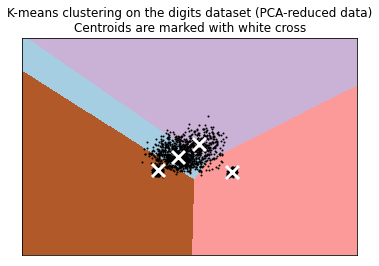

In [202]:
data = df[feats_emb]
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.005  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()